# Шаг 1. Загрузка данных и подготовка к анализу

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

Помещаем данные о визитах, заказах и расходах в переменные:

In [2]:
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('/datasets/costs_info_short.csv'),
)

Проверка типов данных:

In [3]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

Приведем названия столбцов к нижнему регистру. И заменим в названиях столбцов все пробелы на символы нижнего подчеркивания.

In [4]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()
visits.columns = visits.columns.str.replace(" ", "_")
orders.columns = orders.columns.str.replace(" ", "_")
costs.columns = costs.columns.str.replace(" ", "_")

Приведем данные о дате и времени к формату Datetime. Остальные пока не будем изменять. 

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

Выведем информацию о датафреймах:

In [6]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

В каждой из таблиц количество ненулевых значений полей одинаковое. Следовательно, пропусков (ячеек со значениями "NaN") - нет. Воспользуемся методом "drop_duplicates". Заново выведем информацию о датафреймах.

In [7]:
visits  = visits.drop_duplicates()
orders  = orders.drop_duplicates()
costs  = costs.drop_duplicates()
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 16.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.2 

Размеры датафреймов не изменились, следовательно, полностью дублирующих друг друга строк не было.

Вывод о качсестве данных: Предоставленные данные пригодны для анализа. Поля таблиц с датами/временем перевелись в формат Datetime без ошибок. Дубликаты и пропуски отсутствовали. 

# Шаг 2. Задание функций для расчета и анализа LTV, ROI, удержания и конверсии

Задаем функцию для создания пользовательских профилей:

In [8]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    #for event in event_names:
    #    if event in events['event_name'].unique():
    #        profiles[event] = profiles['user_id'].isin(
    #            events.query('event_name == @event')['user_id'].unique()
    #        )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Задаем функцию для расчета удержания

In [9]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
     # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Задаем функцию для расчета конверсии

In [10]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Задаем функцию для расчета LTV и ROI

In [11]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Задаем функцию для визуализации удержания

In [12]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

Задаем функцию для визуализации конверсии

In [13]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Задаем функцию для визуализации LTV и ROI

In [14]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Функция для сглаживания фрейма.

In [15]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

# Шаг 3. Исследовательский анализ данных

3.1 Создание пользовательских профилей. Определение минимальной и максимальной даты привлечения пользователей.

In [16]:
profiles = get_profiles(visits, orders, costs)
print(profiles) 

             user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt      mon

In [17]:
first_ts_min = (profiles['first_ts'].min()).date()
first_ts_max = (profiles['first_ts'].max()).date()
print(first_ts_min)
print(first_ts_max)

2019-05-01
2019-10-27


Минимальная и максимальная дата первого посещения среди пользователей совпадает с границами, обозначенными в условии - с 1го мая по 27 октября. 

3.2 Анализ платящих и неплатящих пользователей из разных стран

In [18]:
payer_percentage_table = profiles.groupby('region').agg({'user_id':'count', 'payer':'sum'})
payer_percentage_table['payer_percentage'] = round(100*(payer_percentage_table['payer']/payer_percentage_table['user_id']),1)
payer_percentage_table = payer_percentage_table.drop(columns = 'payer').sort_values(by = 'user_id', ascending = False).rename(columns = {'user_id':'users_count'})
print(payer_percentage_table)

               users_count  payer_percentage
region                                      
United States       100002               6.9
UK                   17575               4.0
France               17450               3.8
Germany              14981               4.1


Больше всего пользователей - из США. Больше всего платящих пользователей - также из США. Количество пользователей из США более чем в 5 раз превышает количество пользователей из идущей на втором месте Великобритании.

3.3 Устройства, которыми пользуются клиенты

In [19]:
payer_percentage_table = profiles.groupby('device').agg({'user_id':'count', 'payer':'sum'})
payer_percentage_table['payer_percentage'] = round(100*(payer_percentage_table['payer']/payer_percentage_table['user_id']),1)
payer_percentage_table = payer_percentage_table.drop(columns = 'payer').sort_values(by = 'user_id', ascending = False).rename(columns = {'user_id':'users_count'})
print(payer_percentage_table)

         users_count  payer_percentage
device                                
iPhone         54479               6.2
Android        35032               5.9
PC             30455               5.0
Mac            30042               6.4


Больше всего пользователей заходят с Iphone. Iphone c существенным отрывом опережает идущие "близко" остальные устройства. При этом, процент платящих с разных устройств сильно не отличается. 

3.4 Анализ каналов привлечения пользователей

In [20]:
payer_percentage_table = profiles.groupby('channel').agg({'user_id':'count', 'payer':'sum'})
payer_percentage_table['payer_percentage'] = round(100*(payer_percentage_table['payer']/payer_percentage_table['user_id']),1)
payer_percentage_table = payer_percentage_table.drop(columns = 'payer').sort_values(by = 'user_id', ascending = False).rename(columns = {'user_id':'users_count'})
print(payer_percentage_table)

                    users_count  payer_percentage
channel                                          
organic                   56439               2.1
FaceBoom                  29144              12.2
TipTop                    19561               9.6
OppleCreativeMedia         8605               2.7
LeapBob                    8553               3.1
WahooNetBanner             8553               5.3
RocketSuperAds             4448               7.9
MediaTornado               4364               3.6
YRabbit                    4312               3.8
AdNonSense                 3880              11.3
lambdaMediaAds             2149              10.5


С отрывом почти в два раза идущий на первом месте органический траффик опережает идущий на втром месте Faceboom. Но у органического траффика ожидаемо самый низкий процент платящих пользователей. А самый большой процент платящих - от идщего на втором месте Faceboom.

Промежуточный вывод: с высокой вероятностью аудитория приложения небедная, активно пользуется Iphone и Facebook. Особенно учитывая преобладание органического траффика. Тем не менее, нельзя однозначно утверждать, что пользователи приложения предпочитают Iphone другим устройствам, а Facebook другим соцсетям, поскольку мы не знаем, в пользу каких устройств и соцсетей была настроена реклама. 

# Шаг 4. Маркетинг

4.1 Общая сумма расходов на маркетинг. Распределение трат по источникам

In [21]:
total_costs = round(sum(costs['costs']),1)
print(total_costs)

105497.3


In [22]:
costs_by_channel = costs.groupby('channel').sum().sort_values(by = 'costs', ascending = False)
print(costs_by_channel)

                       costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22


Больше всего затрат на рекламу приходится на сети Facebook и Tik-Tok, которые ожидаемо и находятся на втором и третьем (после органического траффика) месте по количеству привлеченных пользователей. Объем затрат на рекламу в Facebook (2е место по затратам среди каналов) превышеат объем затрат на канал Wahoo, находящийся на третьем месте в 6 раз! Пдобных разрвывов не наблюдается в количестве привлеченных пользователей (п. 3.4). 

Построим график "время - затраты на рекламу". Используем скользящие средние за две недели (14 дней). 

Text(0, 1, 'Затраты, $')

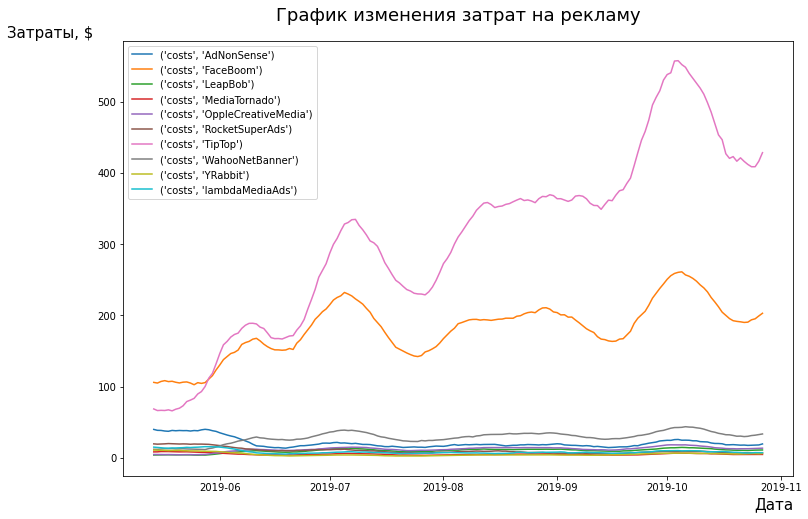

In [23]:
grouped_by_date = costs.groupby(['channel','dt']).sum('costs')
pivot_for_plot = grouped_by_date.pivot_table(index = 'dt', columns = 'channel').rolling(14).mean()
plt.figure(figsize=(12, 8))
plt.plot(pivot_for_plot)
plt.legend(pivot_for_plot.columns)
plt.title('График изменения затрат на рекламу',fontsize = '18', pad = 20)
plt.xlabel('Дата', fontsize = '15', loc = 'right')  
plt.ylabel('Затраты, $', fontsize = '15', rotation = 0, loc = 'top')

Видно, что затраты на маркетинг в соцсети TikTok постоянно растут. На Facebook - в первую треть временнного интервала - растут, впоследствии рост останавливается. Вероятно, имеет значение наличие пиков в июле и октябре. И то, что эти пики появляются синхронно по всем платформам. 

4.2 Расчет САС

Определим среднюю стоимость привлечения одного пользователя из каждого источника.

C отрывом почти в три раза лидирует TikTok. 

Определим средний САС на одного пользователя для всего проекта.

In [27]:
profiles_no_organic = profiles.query('channel != "organic"')
print('Средняя стоимость привлечения одного пользователя для всего проекта - ',
      round(costs['costs'].sum()/len(profiles_no_organic),2),'$')

Средняя стоимость привлечения одного пользователя для всего проекта -  1.13 $


Строим график CAC по каналам привлечения.

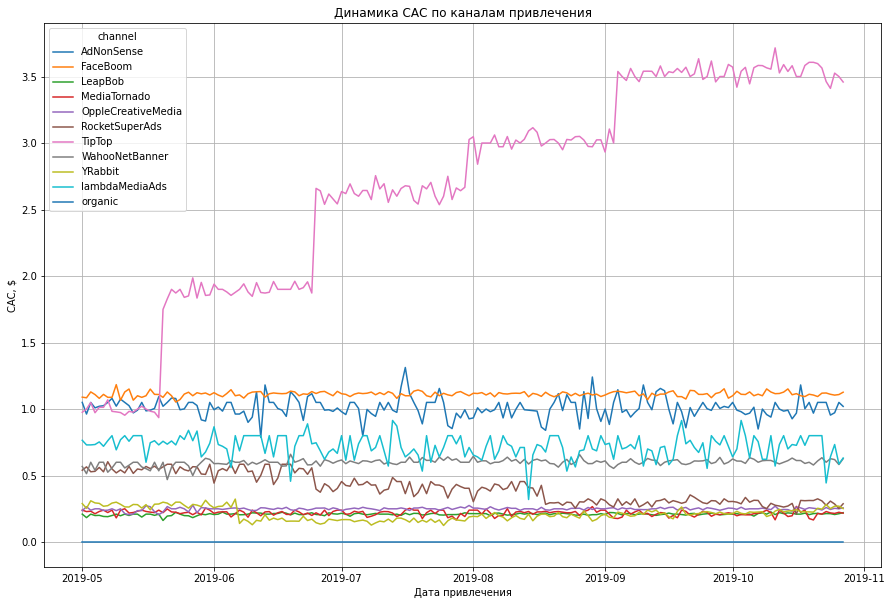

In [28]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 10))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

По всем каналам кроме TikTok CAC стабилен в течение периода. Отметим амплитуду колебаний СAC для Facebook - она существенно меньше амплитуды колебаний САС для других источников. Для канала TikTok СAC скачкообразно растет, будучи в начале периода сопоставимым с СAC для Facebook, к концу исследуемого периода становится в 3,5 раза больше. Следует обратить внимание на даты, в которые произошли скачки. Вероятно, были сбои в настройках кампаний.

Промежуточный вывод: гипотеза о причинах убытков: "Убытки могут быть обусловлены сбоями в настройках рекламных кампаний в TikTok".

# Шаг 5. Оценка окупаемости рекламы для привлечения пользователей

5.1 Графики LTV и ROI

Согласно условию проекта принимаем дату исследования 1 ноября 2019, горизонт рассмотрения 14 дней.

In [29]:
profiles_no_organic = profiles.query('channel != "organic"')

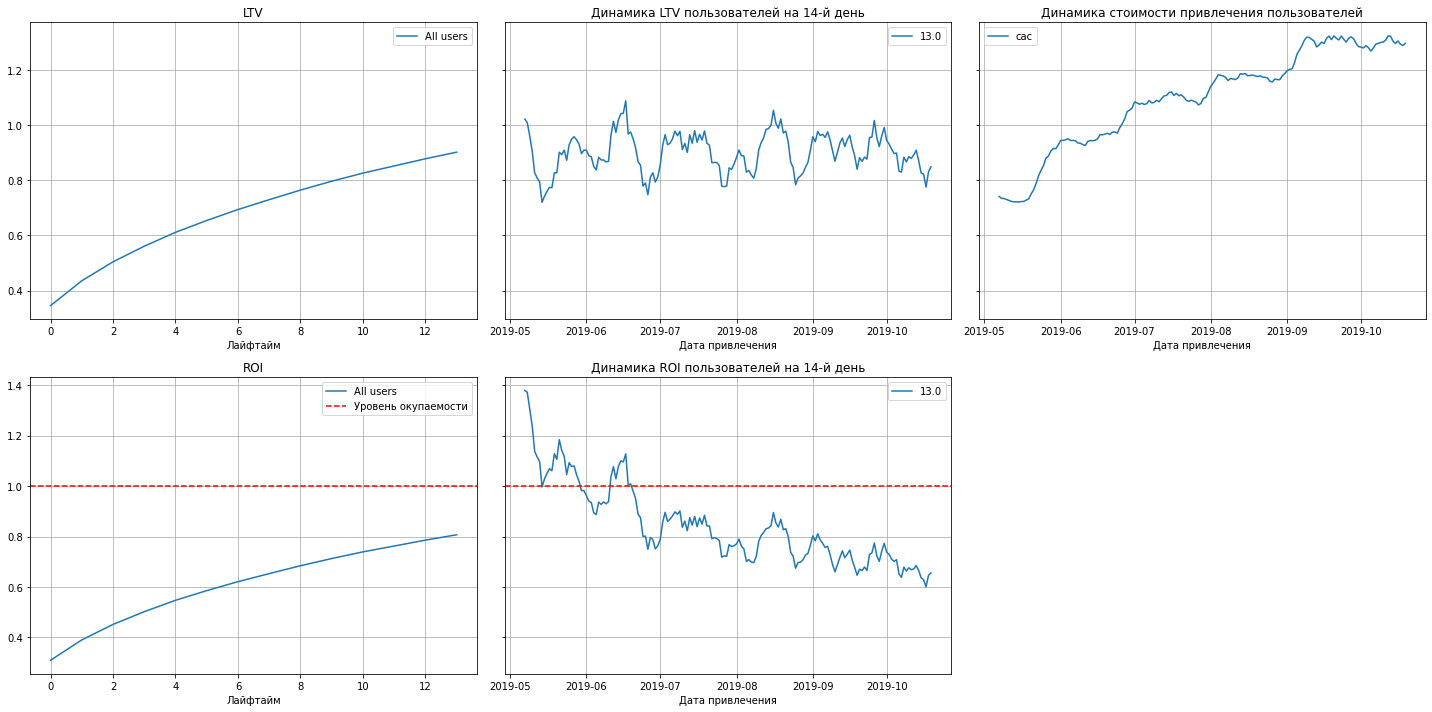

In [30]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic, orders, pd.to_datetime('2019-11-01'), 14
)
#print(ltv_history)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14)

Кривая окупаемости,двигаясь вниз, пересекает уровень окупаемости примерно через месяц после крупного скачка в САС. Скачкообразная структура кривой САС напоминает кривую САС для TikTok, очевидно испытывая сильльное влияние последней.

Кривая окупаемости (динамика ROI на 14й день), двигаясь вниз, окончательно пересекает уровень окупаемости примерно через месяц после крупного скачка в САС. Скачкообразная структура кривой САС напоминает кривую САС для TikTok, очевидно испытывая сильльное влияние последней.
Кривая LTV (пожизненная стоимость клиентов) растет ожидаемым образом. Рост замедляется. 

5.2 Анализ окупаемости рекламы с разбивкой по рекламным каналам

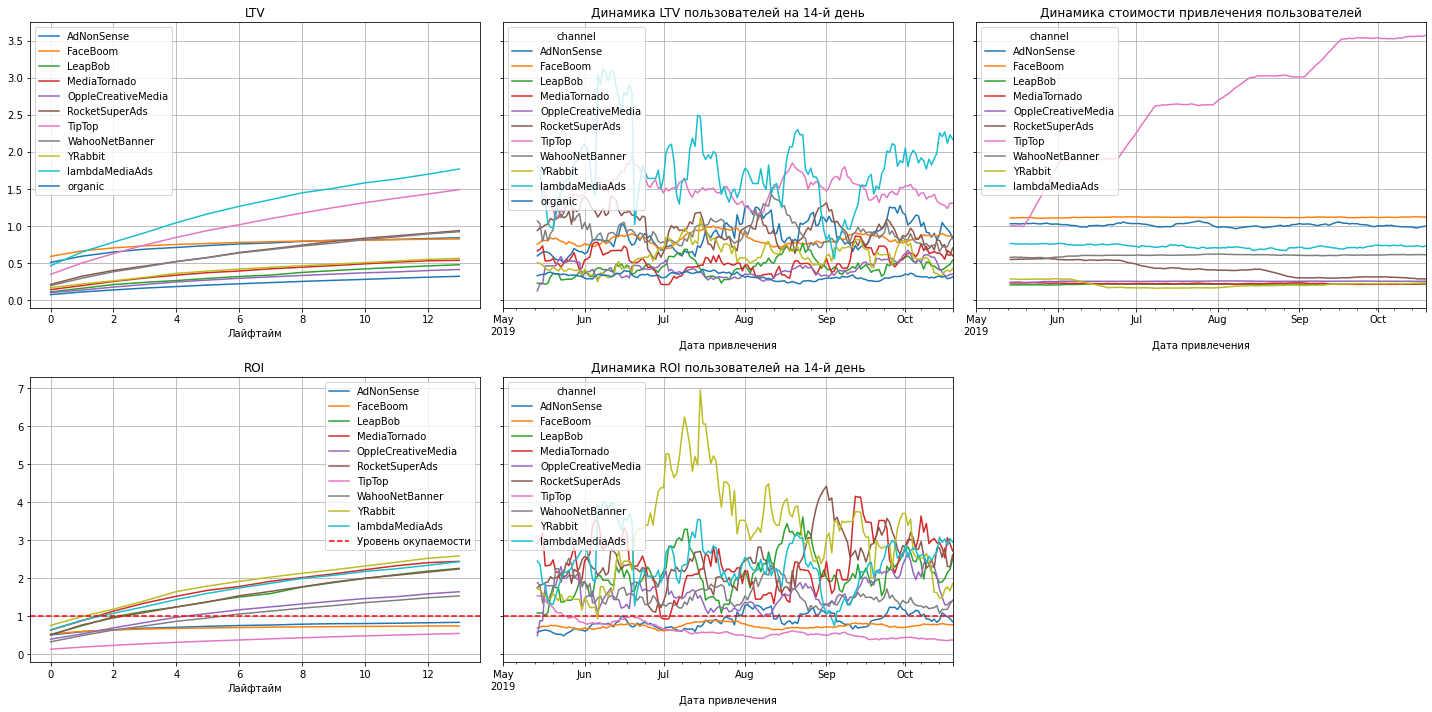

In [31]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, pd.to_datetime('2019-11-01'), 14, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, 14, window=14
) 

Реклама не окупается в TikTok, Facebook и еще двух сетях. Учитываем, что: 1) Tik Tok и Facebook являются лидерами по количеству привлеченных пользователей 2) Затраты на рекламу в TikTok растут не так, как на рекламу в остальных источниках. Соответствено, предположение об ошибке в настройке рекламных кампааний в TikTok становится все более актуальным. 

5.3 Анализ окупаемости рекламы с разбивкой странам

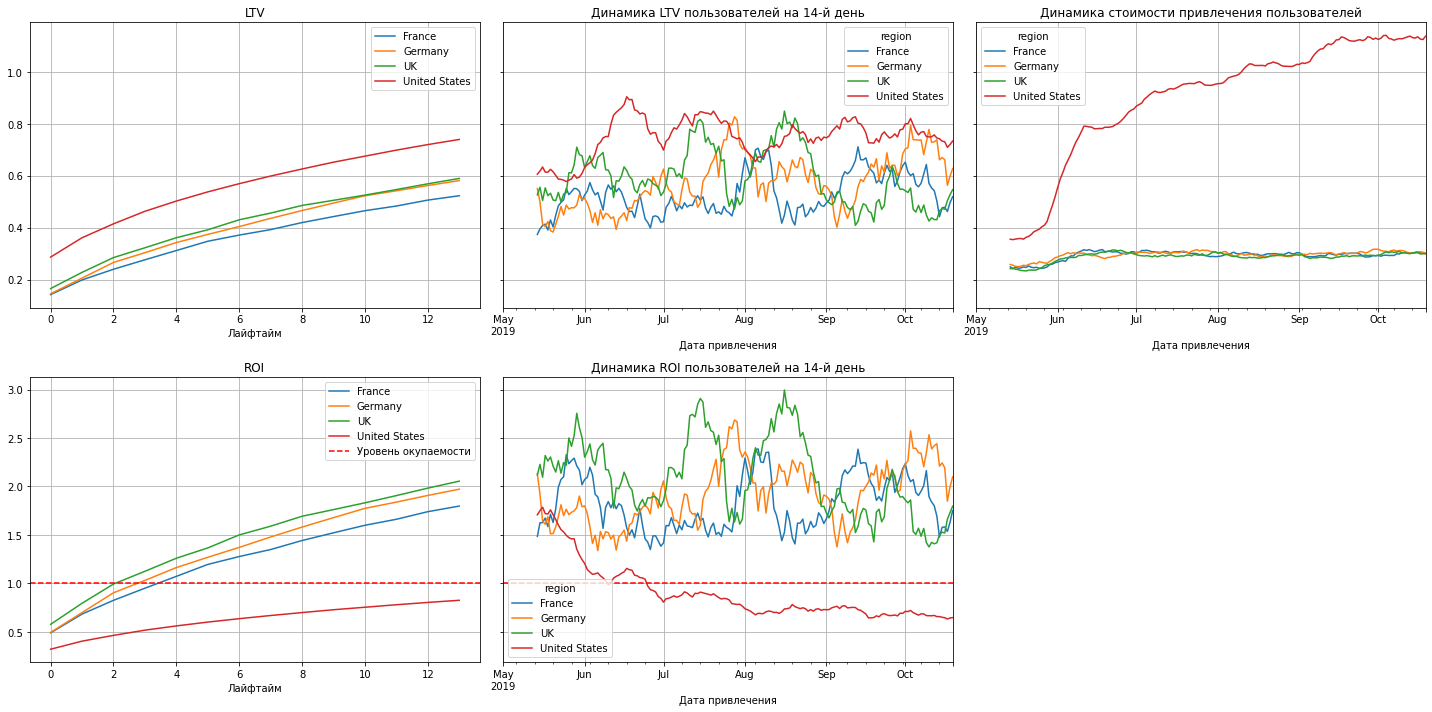

In [32]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, pd.to_datetime('2019-11-01'), 14, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, 14, window=14
) 

Реклама не окупается только в США. Подозрительный рост CAC, также, имеет место только для США. Соответствено, предполагаем, что проблема с рекламными кампаниями в TikTok локализована в CША. Поскольку на США приходится больше полльзователей, чем на остальные страны вместе взятые, то графики для США естествнным образом влияют на графики, интегрированные по всем странам.  

Кривая динамики ROI пользователей на 14й день по всем странам кроме США превышает уровень окупаемости. По США - двигаясь вниз, окончательно пересекает уроверь окупаемости в середине июня - как уже упоминалось выше - через месяц после крупного скачка стоимости привлечения клиента в TikTok и общей стоимости привлечения клиента для всех каналов.
При этом LTV для США стабильно (на постоянное значение) выше, чем для других стран. То есть, средний пользователь из США приносят больше выручки, чем средний пользователь из других стран. 

5.4 Графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

График с разбивкой по устройствам:

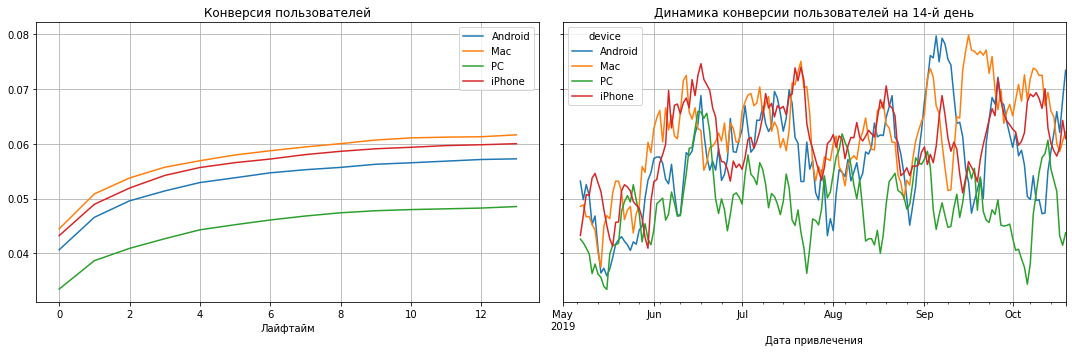

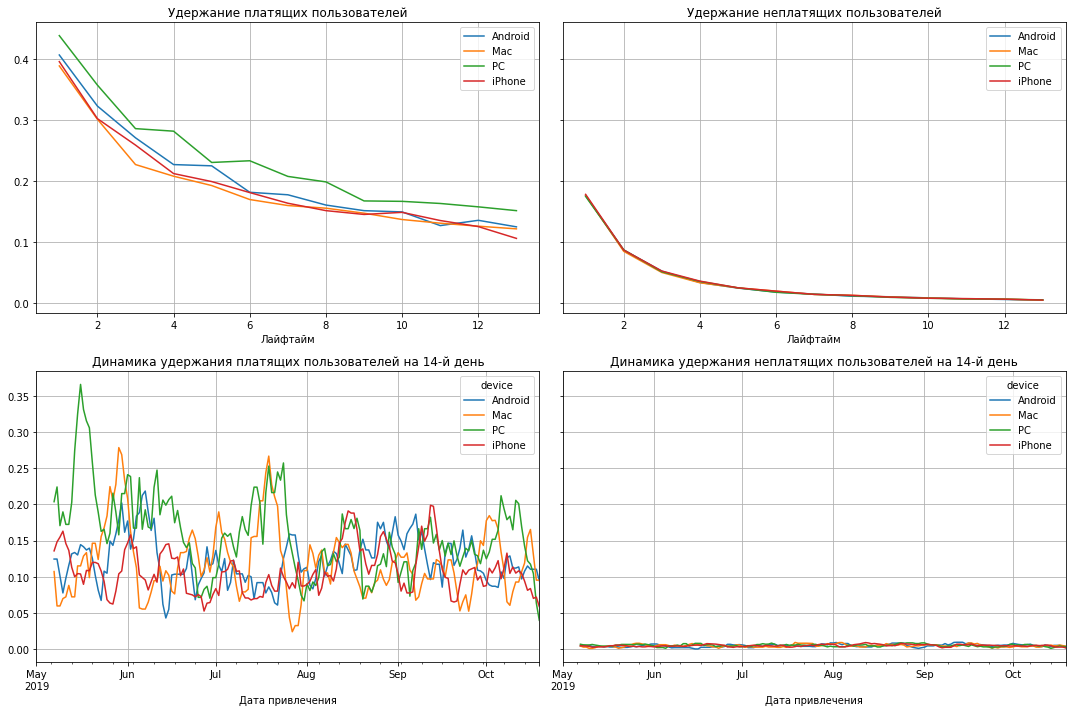

In [33]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, pd.to_datetime('2019-11-01'), 14, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, 14) 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, pd.to_datetime('2019-11-01'), 14, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, 14)

График с разбивкой по странам:

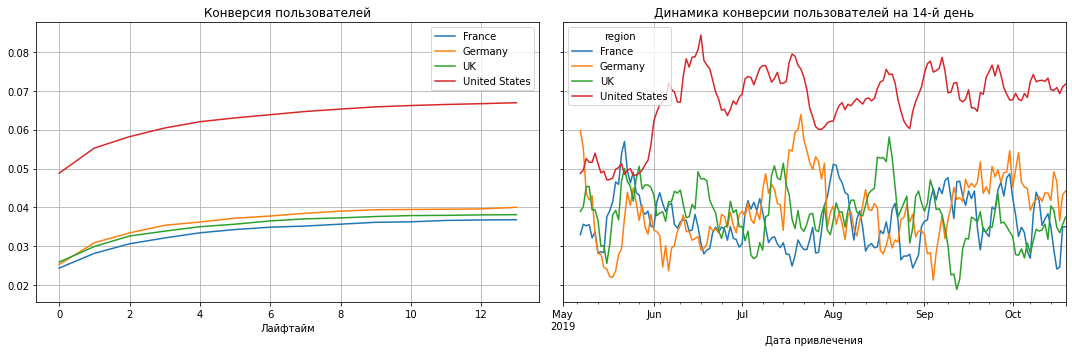

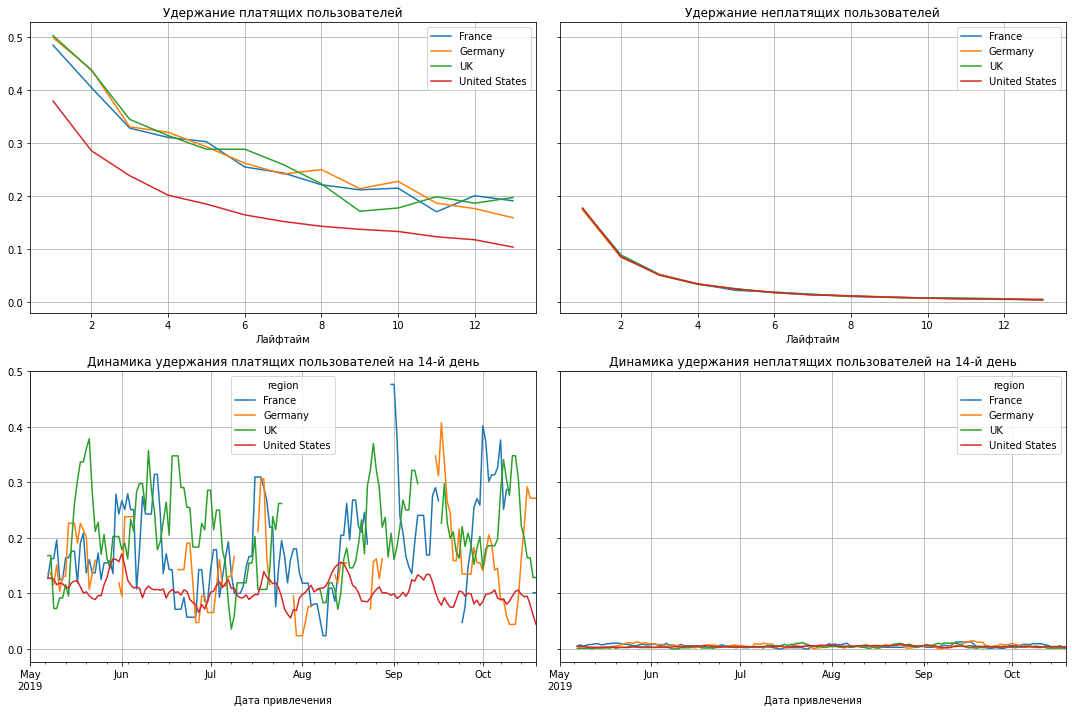

In [34]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, pd.to_datetime('2019-11-01'), 14, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, 14) 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, pd.to_datetime('2019-11-01'), 14, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, 14)

График с разбивкой по каналам привлечения:

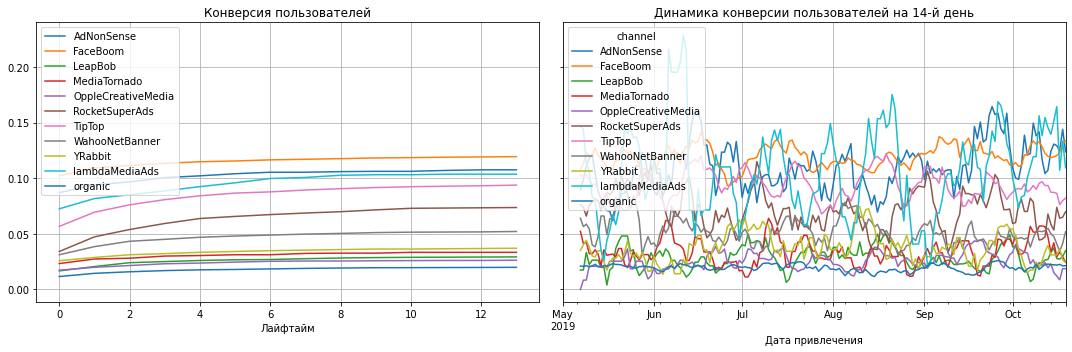

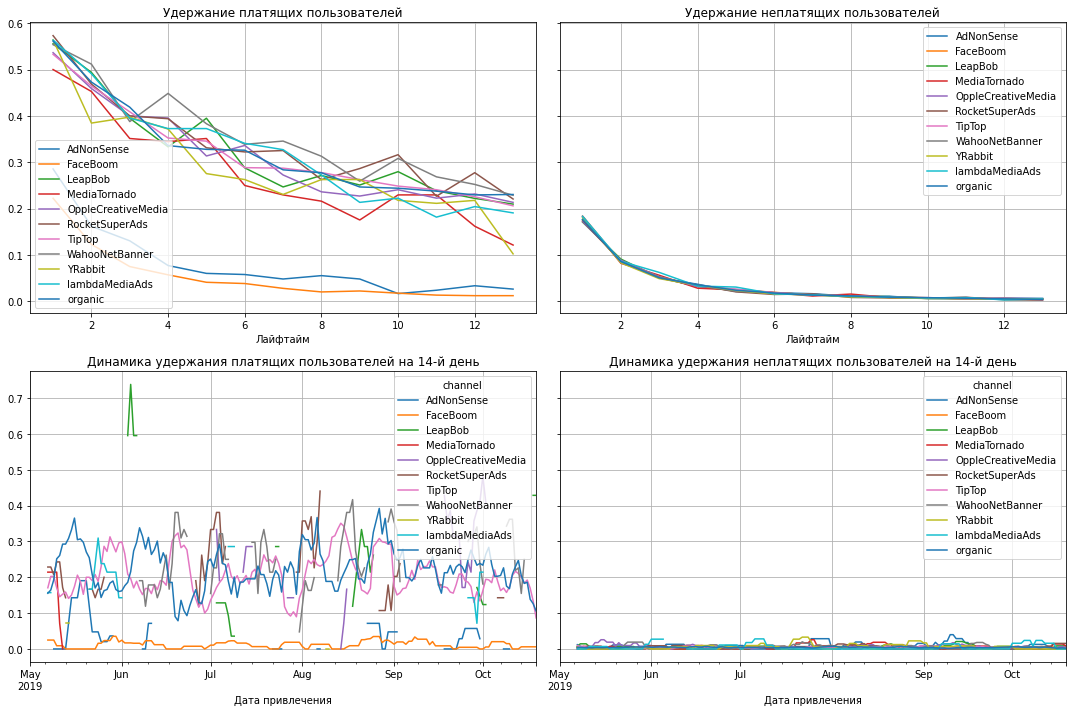

In [35]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, pd.to_datetime('2019-11-01'), 14, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, 14) 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, pd.to_datetime('2019-11-01'), 14, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, 14)

Удержание пользователей падает по всем странам, каналам и устройствам. В целом, реклама не окупается. США, TikTok снижают окупаемость рекламы. Проблемы окупаемости, вероятно, вызваны регулярными сбоями в настройках рекламных кампаний в этой сети в США. Пользователи из США конвертируются лучше пользователей из других стран. Конверсия пользоваталей, пришедших их TikTok - средняя среди всех сетей. Вероятен сценарий, при которой специалист по рекламе, видя высокую конверсию пользователей в США ошибочно распределил бюджет в пользу TikTok в этой стране, причем сделал это несколько раз подряд с интевалом примерно месяц. 

По конверсии пользователи, использующие технику фирмы Apple (Iphone и Mac) опережают другие категории. С заметным отрывом отстает конверсия пользователей PC. При этом по удержанию пользователи Iphone и Mac занимают последние два места, отставая от PC и Android. 
Удержание платящих пользователей c отрывом от группы всех остальных стран отстает в США. Удержаение на Facebook со стабильным отрывом отстает от удержания на других платформах.  

Получается, что пользователи из США хорошо конвертируются (особенно на Iphone и Mac), но плохо удерживаются.  

# Шаг 6. Выводы

6.1 Причины неэффективности привлечения пользователей

Ошибочное распределение бюджета в пользу TikTok в США. 

6.2 Рекомендации для отдела маркетинга

Попробовать перераспределить бюджет на рекламу в США от TikTok в пользу других каналов. Также, проверить, не было ли ошибок в настройках рекламных кампаний в TikTok в США. А также, попробовать перераспределить бюджет в пользу Великобритании, поскольку именно по UK наблюдаются наибольшие значения ROI.

Распределение бюджета в пользу TikTok ошибочно поскольку согласно графику ROI этот канал не окупается при постоянном росте вложений, в итоге которого к концу периода стоимость привлечения одного пользователя через ТikTok становится в 3,5 раза выше стоимости привлечения для самого "дорогого" из остальных каналов. 

Другой убыточный канал - Facebook. По нему - стабильно наибольшая САС (не считая TikTok), медленнее всего растет LTV, и экстремально плохое удержаение (существенный отрыв от других каналов в худшую сторону). Таким образом, низкая окупаемость рекламы в Facebook, вероятно, обусловлена 1) особенностями пользователей Facebook 2) ошибками в настройках кампаний в Facebook 3) неудачными решениями в создании рекламного контента. Канал остается убыточным, даже несмотря на то, что пользователи Facebook конвертируются лучше других.

Также, не окупается AdNoSense. По нему - стабильно высокая (на уровне Facebook) стоимость привлечения одного пользователя. Пользователи хорошо конвертируются и удерживаются "не хуже других". Вероятно, проблема, как и в Facebook - в настройках кампаний, при которых один пользователь стоит очень дорого.

Рассмотрим окупаемость рекламы с разбивкой по рекламным каналам в США.

In [36]:
usa_profiles = profiles.query('region == "United States"')

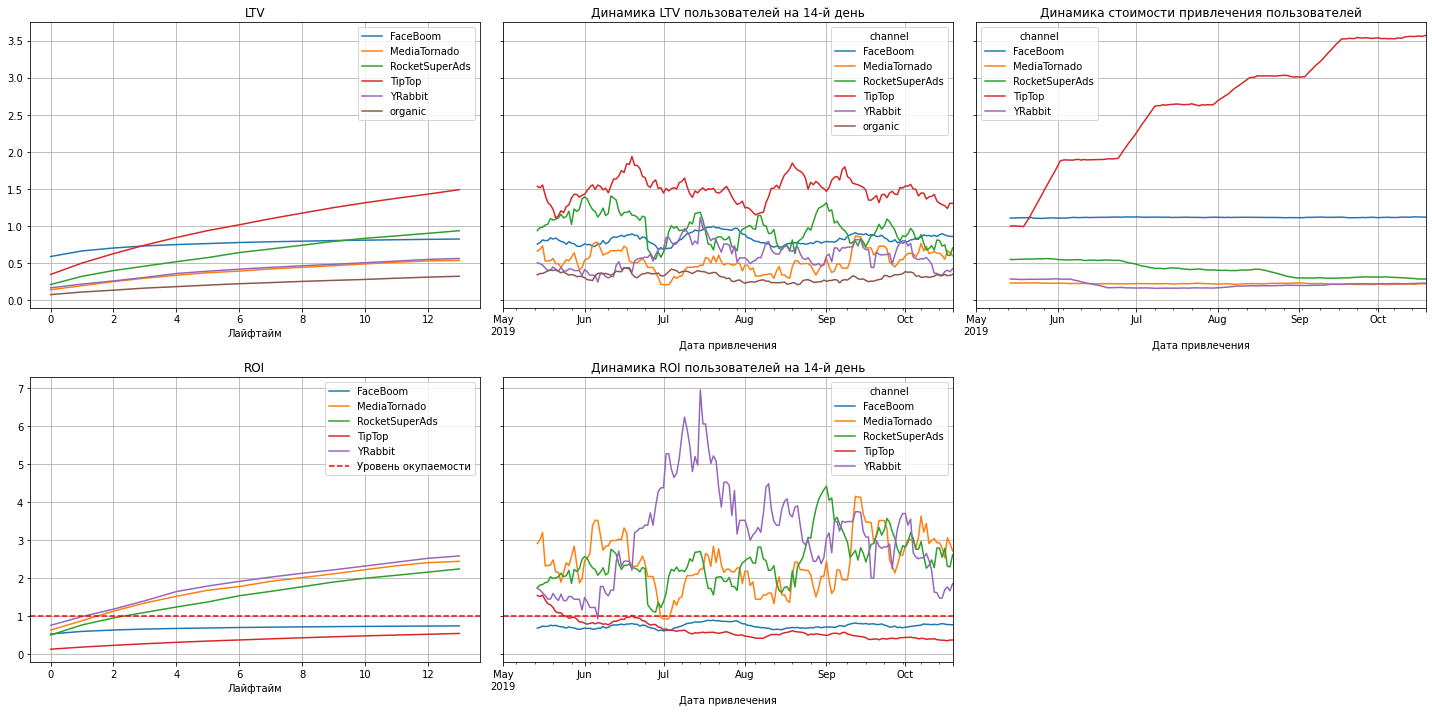

In [37]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    usa_profiles, orders, pd.to_datetime('2019-11-01'), 14, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, 14, window=14
) 

В США, как и по "всем регионам вместе" не окупаются Facebook и TikTok. При этом лучше всех (ROI и СAC) показывает себя канал "YRabbit". Его стоит рассмотреть в качестве альльтернативного канала для рекламных влложений в первую очередь.